## Question 1

The problem is:
$$\max_{\{c_t,k_t\}_{t=0}^\infty} \sum_{t=0}^\infty \beta^t \log(c_t)$$
s.t.
$$ c_t+k_{t+1} = A k_t^\theta +(1-\delta)k_t$$
The FOCs imply that:
$$ \frac{c_{t+1}}{c_t} = \beta (A\theta k_{t+1}^{\theta-1} + 1-\delta)$$
Hence, $$k_{ss} = \left(\frac{1-\beta(1-\delta)}{\beta A \theta}\right)^{\frac{1}{\theta-1}} $$



The functional equation is:
$$F(c)(k) =  1-\beta \frac{c(k)}{c(Ak^\theta +(1-\delta)k-c(k))}(A\theta (A\theta k^\alpha + (1-\delta)k - c(k))^{\theta-1} + 1-\delta)  = 0$$

And, in the test case $\delta = 1$, we know the closed form solution:
$$c(k) = (1-\beta \theta) A k^{\theta} $$ 



Let us now define some parameters and find the Steady State value of capital:

In [1]:
using Plots, Optim, LinearAlgebra, FastGaussQuadrature

#Defining parameters
θ = 0.25
β = 0.9
δ = 1
A = (1-β*(1-δ))/(θ * β) #This will normalize the SS to 1
kss = ((1- β*(1-δ))/(β*A*θ))^(1/(θ-1))

1.0

We will use the finite element method with the piecewise linear base function $\varphi_i$ defined below (and in the lecture notes):


In [2]:
#Finite elements Piecewise Linear function:
function ϕi(x,X,i::Int)
    #x: point to evaluate the function
    #X: Vector with elements nodes
    #i: Which element in the function
    if i>1 && i<length(X) #i is not in a boundary
        if X[i-1]<=x<=X[i]
            f = (x-X[i-1])/(X[i]-X[i-1])
        elseif X[i]<=x<=X[i+1]
            f = (X[i+1]-x)/(X[i+1]-X[i])
        else
            f = 0
        end
    elseif i==1 #i is in the boundary(1)
        if X[i]<=x<=X[i+1]
            f = (X[i+1]-x)/(X[i+1]-X[i])
        else
            f = 0
        end
    elseif i==length(X) #i is in the top boundary
        if X[i-1]<=x<=X[i]
            f = (x-X[i-1])/(X[i]-X[i-1])
        else
            f=0
        end
    end
    return f
end


ϕi (generic function with 1 method)

The elements node $k_i\in[0,2]$ with their distance increasing exponentially since it is known that the consuption function is less linear close to 0. We have 15 nodes.

In [3]:
#Defining the elements:
#In this case, we are putting more elements at low values of k because the function is known to be "less linear" in that region.
K = zeros(15)
for i=2:length(K)
    global K
    K[i] = K[i-1] +0.0005*exp(0.574*(i-2))
end
K

15-element Array{Float64,1}:
 0.0                  
 0.0005               
 0.0013876771423281366
 0.0029636185603518304
 0.0057614729092074785
 0.010728655615292541 
 0.019547164715211198 
 0.03520314263003213  
 0.06299805010159346  
 0.11234385817285451  
 0.19995014996199395  
 0.35548235545269025  
 0.6316071228726379   
 1.1218264118113592   
 1.9921393268498697   

We will approximate the consumption functio $c(k)$ by:
$$ c^n(k;\alpha) = \sum_{i=1}^n\alpha_i\varphi_i(k)$$

In [4]:
function cn(k,α;K=K)
#This function is piecewise linear approximation for a function with arguments k
#To get a good approximations one need to find the parameters α
#K are the elements nodes. It is optionally defined here for efficiency. 
        n = length(K)
        c = 0
        for i = 1:n
            c = c + α[i]*ϕi(k,K,i)
        end
        return c
end

cn (generic function with 1 method)

The Residual equation is:

$$R(k;\alpha) = F(c^n(k;\alpha))$$
$$ =  1-\beta \frac{\sum_{i=1}^n\alpha_i\varphi_i(k)}{\sum_{i=1}^n\alpha_i\varphi_i(Ak^\theta +(1-\delta)k-\sum_{i=1}^n\alpha_i\varphi_i(k))}(A\theta (A\theta k^\alpha + (1-\delta)k - \sum_{i=1}^n\alpha_i\varphi_i(k))^{\theta-1} + 1-\delta)  = 0$$

In [5]:
#capital policy function from Bugdet constraint
polk(k,α) = min(max(eps(),A*k.^θ+(1-δ)*k-cn(k,α)),K[end])
#min max are needed to avoid NaNs and other numerical instabilities

function residual(k,α)
    #This function is specific for the deterministic growth model.
    #Residual function comes from FOCs
    #cn below is an approximation for consumption
        R = cn(k,α)/cn(polk(k,α),α) * β * (A*θ*polk(k,α)^(θ-1)+1-δ)- 1
    return R
end

residual (generic function with 1 method)

Since the finite element method is a Galerkin method, the base function is the weight we use to minimize the weighted residual:
$$ \min_\alpha \int_0^\bar{k} \varphi_i(k) R(k;\alpha) dk $$
To calculate the integral, we use Gauss-Legendre method with 3 nodes per element. Also note, that we impose the boundary condition $\alpha_1 = 0$ since this imply $c(0) = 0$.

In [6]:
function integra(k,α;K=K)
#This function calculates the function that will be integrated:
#integra(k;α):= ϕi(k)R(k;α), where ϕi are the weights and R is the residual function
#In the Finite element methods, the weights are the same as the approximating functions
    T=zeros(length(K))
    for i=1:length(K)
        T[i] = ϕi(k,K,i)*residual(k,α)
    end
    return T
end

#This function calculates the integral (the norm of the integrated functions), as a functions of the parameters to minimized
#We define that way since this is the format accepted by the solver:
#mini(α):= ∫integra(k;α)dk
nodes, weights = gausslegendre(3*(length(K)-1)) #Gauss Legendre nodes and weights,this function is just a Quadrature table
function mini(α;nodes=nodes,weights=weights,K=K)
    if length(α)<length(K)
        α = vcat(0,α)
    end
    #g = quadgk.(integra,K[1],K[end])[1] #Integral
    #See Judd's book pg 261 on numerical integration and the gausslegendre formula:
    gaussleg = zeros(length(K))
    for j=1:length(nodes)
        gaussleg .+= (K[end]-K[1])/2 .* weights[j] .* integra((nodes[j] .+1).*
        (K[end]-K[1])/2 .+ K[1],α)
    end
    return norm(gaussleg,1)
end

mini (generic function with 1 method)

Let's start the minimization procedure. We use the BFGS method which is a Quasi-Newton method. It does not calculates the Hessian as a Newton procedure would do, but it approximates the Hessian by a positive definite approximation which is easier to compute and invert (see Judd's book). Note that this minimization step is extremely sensitive to initial conditions. A grid search or another procedure might be needed to determine the initial parameters.

In [7]:
#Setting initial conditions
initial =  ones(length(K)-1) .* range(0.35, stop = 3.5, length = length(K)-1)

#Check if the initial conditions are somewhat close to the true parameters. 
mini(initial)


0.6613235916442249

In [8]:
#Here we start the minimization procedure we want to find α:= argmin mini(α)

#Solver stuff
#lower and upper bound of the parameters:
lower = zeros(length(initial))
upper = Inf*ones(length(initial))
#Optimizer method is BFGS, see Judd's book page 114 for an explanation:
inner_optimizer = BFGS()

#Solver:
bla = optimize(mini,lower,upper,initial, Fminbox(inner_optimizer))
#Parameters
α = vcat(0,bla.minimizer) #we need to concatenate to include the boundary condition

15-element Array{Float64,1}:
 0.0                
 0.37442113219372514
 0.6640748582488243 
 0.8539733791826457 
 0.9252970761844344 
 1.1458792909060764 
 1.29154740222145   
 1.4961818748748827 
 1.730224876203169  
 2.0077754086540636 
 2.3141705183580985 
 2.6711610637841803 
 3.085257330000326  
 3.565426495237902  
 4.116321573422392  

In [9]:
#Checking if the residual is low at the solution
mini(α)

8.706464890141266e-6

Below, we plot the approximate consumption function and the true one. As we can see, the approximation is barely indistinguible from the true function.

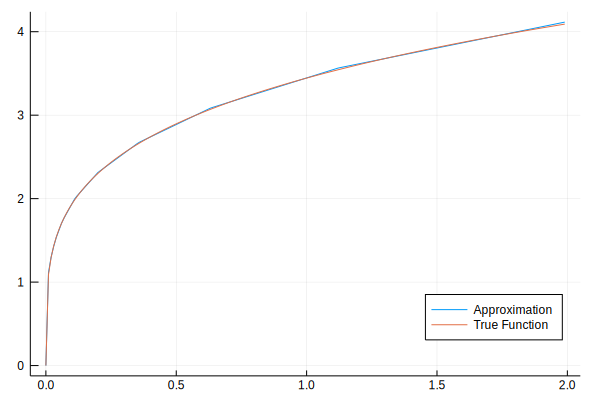

In [10]:
#Plotting
k=K[1]:0.01:K[end]

c(k) = (1-β*θ)*A*k^θ
cnplot(k) = cn(k,α)
plot(k,[cnplot.(k),c.(k)],label=["Approximation" "True Function"],legend=:bottomright)

Now, we do the same procedure for a case with $\delta =0.05$. Note that now we can't compare to a known formula, but the shape should be similar to the one above.

In [11]:
#New parameters
δ = 0.05
A = (1-β*(1-δ))/(θ * β) #This will normalize the SS to 1

kss = ((1- β*(1-δ))/(β*A*θ))^(1/(θ-1))

polk(k,α) = min(max(eps(),A*k.^θ+(1-δ)*k-cn(k,α)),K[end]) #capital policy function from Bugdet constraint

function residual(k,α) #Residual function comes from FOCs
        R = β * cn(k,α)/cn(polk(k,α),α)  * (A*θ*polk(k,α)^(θ-1)+1-δ)- 1
    return R
end

residual (generic function with 1 method)

In [12]:
initial = ones(length(K)-1)*0.0035
for i=2:length(initial)
    global initial
    initial[i] = initial[i-1] +0.000265*exp(0.589*(i-2))
end
initial
#initial = ones(length(K)-1)*0.1.*range(0.03,stop = 8,length = length(K)-1)
mini(initial)

0.560172602119699

In [13]:
#Solver stuff
#lower and upper bound of the parameters:
lower = zeros(length(initial))
upper = Inf*ones(length(initial))
#Optimizer method is BFGS, see Judd's book page 114 for an explanation:
inner_optimizer = BFGS()

#Solver:
bla = optimize(mini,lower,upper,initial, Fminbox(inner_optimizer))
#Parameters
α = vcat(0,bla.minimizer)

15-element Array{Float64,1}:
 0.0                 
 0.01239167265675882 
 0.09230419026395284 
 0.021151728251957085
 0.115504132550029   
 0.12844822914611462 
 0.15135403379323256 
 0.17588563782962213 
 0.20737801051704224 
 0.24777147103586775 
 0.3013961059132636  
 0.3754319853414289  
 0.4808309867565117  
 0.6344669728788809  
 0.852052586048369   

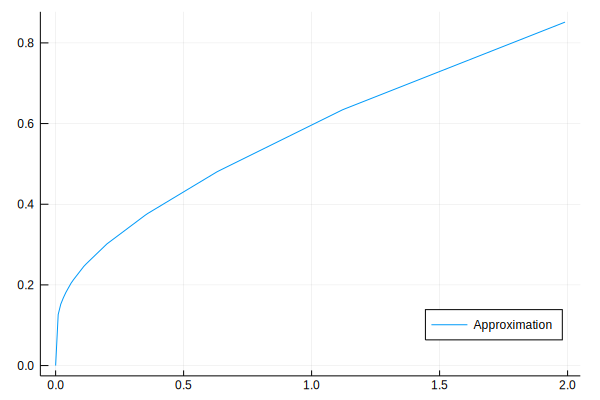

In [14]:
#Plotting
k=K[1]:0.01:K[end]
cnplot(k) = cn(k,α)
plot(k,[cnplot.(k)],label=["Approximation"],legend=:bottomright)

This seems a fair approximation to the consumption function.